In recent weeks, many people have created various studies on coronavirus. Most of them are based on various types of aggregates or microaggregates. The virus has already been several months and therefore more and more interesting and detailed and accurate data appear. Today we will not analyze aggregates, but single cases. **Although this database only applies to one country - South Korea and a lot of deficiencies, but her appearance of this base allows us to get answers to previously unanswered questions**. I invite you for a short analysis in which we'll answer such questions as **"Who is infected?", "How did these people get infected?", "How long does the average duration of treatment take?", "How many people can get infected with one person with coronavirus?"**.

In [1]:
options(warn = -1)
options(scipen = 10000)
options(repr.plot.width = 13.5, repr.plot.height = 9)

library(tidyverse)
library(scales)
library(reshape)
library(RColorBrewer)
library(ggthemes)
library(gridExtra)
library(ggrepel)
library(lubridate)

data <- read.csv("../input/coronavirusdataset/PatientInfo.csv", stringsAsFactors = F)
#data <- data[,-c(4,6,14)]

#data$age <- 2020-data$birth_year
data$Date_Conf <- as.Date(data$confirmed_date)
data$Date_Rec <- as.Date(data$released_date)
#data$Date_Death <- as.Date(data$deceased_date, format = "%m/%d/%y")
data$DaysToRec <- as.numeric(data$Date_Rec-data$Date_Conf)
#data$DaysToDea <- data$Date_Death-data$Date_Conf


#data <- data[,c(1,3,7,10,12,13,5,19:21)]
data <- data[,c(1,2,6,7,8,9,3,15,16,17)]
data$sex[data$sex==""] <- NA
data$infection_case[data$infection_case==""] <- NA
names(data) <- c("ID", "Sex", "Region", "Infection_reason", "Infected_by", "Contact_number", "Age", "Date_Confirm", "Date_Recovered", "Days_To_Recover")
data$Contact_number[data$Contact_number %in% c("-", "1000000772", "1000000796")] <- 0
data$Contact_number <- as.numeric(data$Contact_number)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following object is 

In [2]:
Head <- data[sample(1:nrow(data),5), ]
Head <- Head[order(Head$ID),]
Head

,ID,Sex,Region,Infection_reason,Infected_by,Contact_number,Age,Date_Confirm,Date_Recovered,Days_To_Recover
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<date>,<date>,<dbl>
650,1000000650,NA,Gangdong-gu,Itaewon Clubs,,NA,,2020-05-08,NA,NA
2125,1600000017,female,Nam-gu,contact with patient,1600000013,NA,20s,2020-02-28,2020-03-24,25
3573,4100000034,female,Cheonan-si,contact with patient,4100000006,0,40s,2020-02-28,2020-04-05,37
3992,6001000234,male,Gyeongsan-si,NA,,NA,50s,2020-03-03,2020-03-22,19
4564,6006000021,female,Gimcheon-si,etc,,NA,70s,2020-03-08,2020-03-22,14


The database has a population of several thousand and applies to all individuals with coronawius. **The first person in Korea to detect a virus is a 36-year-old woman** (detected on January 20, 2020). As we can see the database has some missing data.

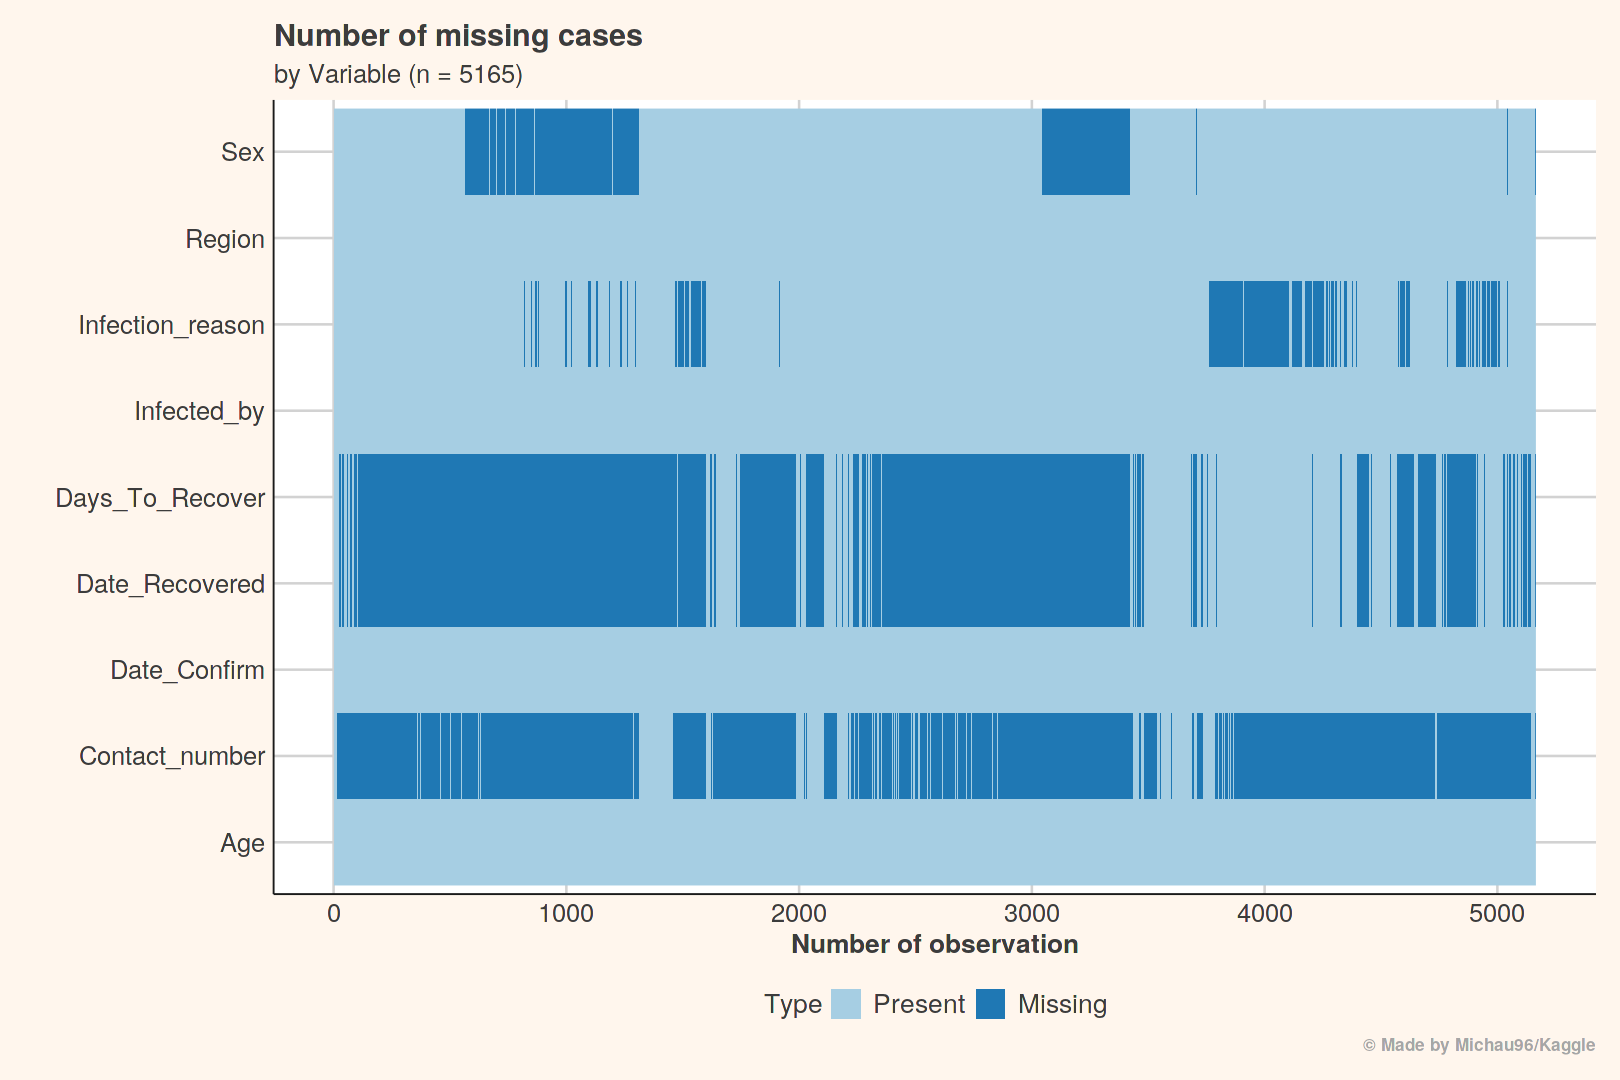

In [3]:
data[,-1] %>% 
  is.na %>%
  melt %>%
ggplot(data = ., aes(X2, X1))+
  geom_raster(aes(fill = value))+
  coord_flip()+
  scale_fill_brewer(palette = "Paired", labels = c("Present","Missing"))+
  theme(axis.text.x  = element_text(angle=45, vjust=0.5))+ 
  labs(x = "", y = "Number of observation", fill = "Type", title = "Number of missing cases", subtitle = "by Variable (n = 5165)", caption = "© Made by Michau96/Kaggle")+ 
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15.5, face = "bold"), axis.text = element_text(size = 15), legend.position="bottom", 
        legend.direction='horizontal', legend.title = element_text(size = 15.5), legend.text = element_text(size = 15.5),
        plot.background = element_rect(fill = "#fff6ed"), axis.line = element_line(size = 0.4, colour = "grey10"), plot.caption = element_text(color = "gray65", face = "bold", size = 10),
        legend.background = element_rect(fill = "#fff6ed"), plot.subtitle = element_text(size = 15), panel.background = element_rect(fill = "white"))
#nrow(data)

We're looking at missing values broken down into variables. The region and infected_by are the only variables (after the ID of course) that has no data. Other variables **have a different number of missing (form 10 to 90%)**. Little cases have values in all variables, which significantly limits the analysis. We have the most information for the oldest cases. It's worth adding that missing values in one variable usually don't coexist with missings in other variables.

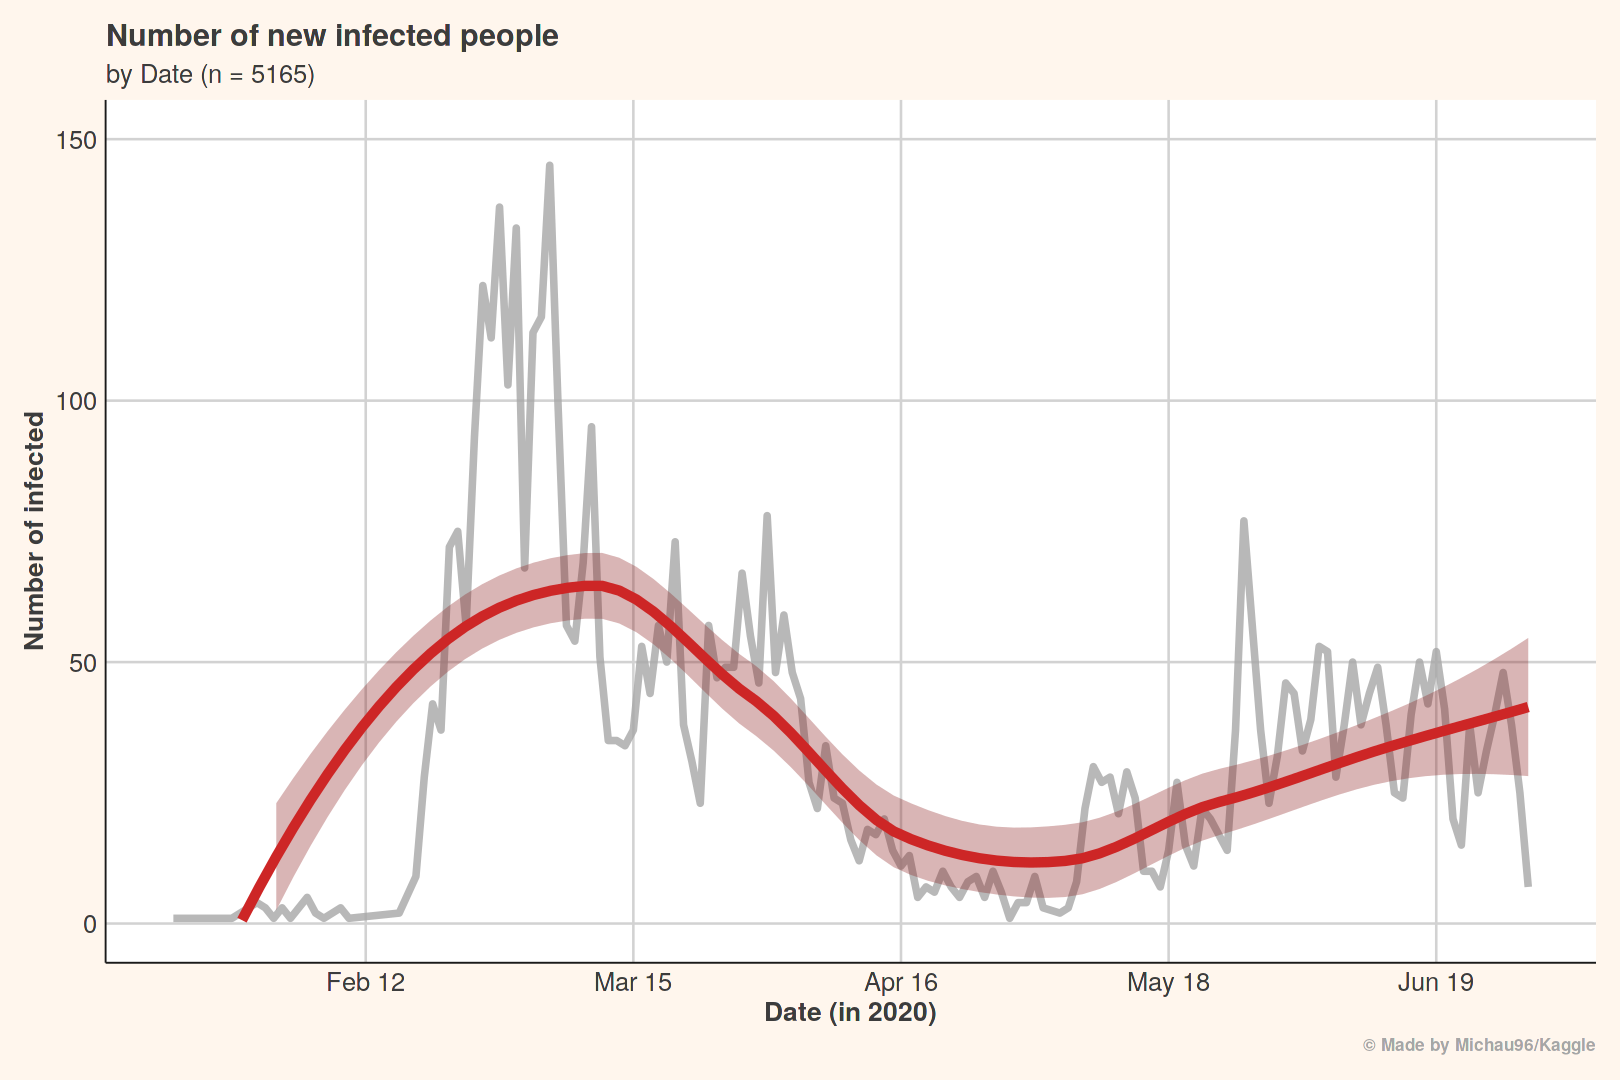

In [4]:
data %>%
  filter(year(Date_Confirm) > 2019) %>%
  group_by(Date_Confirm) %>%
  summarise(x = n()) %>%
ggplot(., aes(Date_Confirm, x))+
  geom_line(size = 1.6, alpha = 0.8, col = "gray65")+
  geom_smooth(method = "loess", color = "firebrick3", size = 2.2, formula = y ~ x, fill = "firebrick4", alpha = 0.32)+
  #geom_point(size = 2.3, alpha = 0.7, col = "gray10")+
  scale_y_continuous(limits = c(0,150))+
  labs(title = "Number of new infected people", subtitle = "by Date (n = 5165)", 
       y = "Number of infected", x = "Date (in 2020)", caption = "© Made by Michau96/Kaggle")+
  scale_x_date(date_labels = "%b %d", date_breaks = "32 days")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15.5, face = "bold"), axis.text = element_text(size = 15), plot.background = element_rect(fill = "#fff6ed"), 
        axis.line = element_line(size = 0.4, colour = "grey10"), plot.subtitle = element_text(size = 15),
        panel.background = element_rect(fill = "white"), plot.caption = element_text(color = "gray65", face = "bold", size = 10))
#nrow(data)

At the beginning we look at the number of new cases over time. The first case was detected on January 20 and for which month only on which days were individual cases identified. **The jump will occur around February 20, where a large number of cases are detected each day**. Mostly, it was detected on March 1 - almost 1,000. After this time, the number of detected cases decreased. In April no more than 30 new cases were recorded per day (usually no more than 10). Another jump occurred at the turn of May and June (the highest value in this period was observed on May 27 and amounted to 76 cases in one day), which resulted in the restoration of some restrictions.

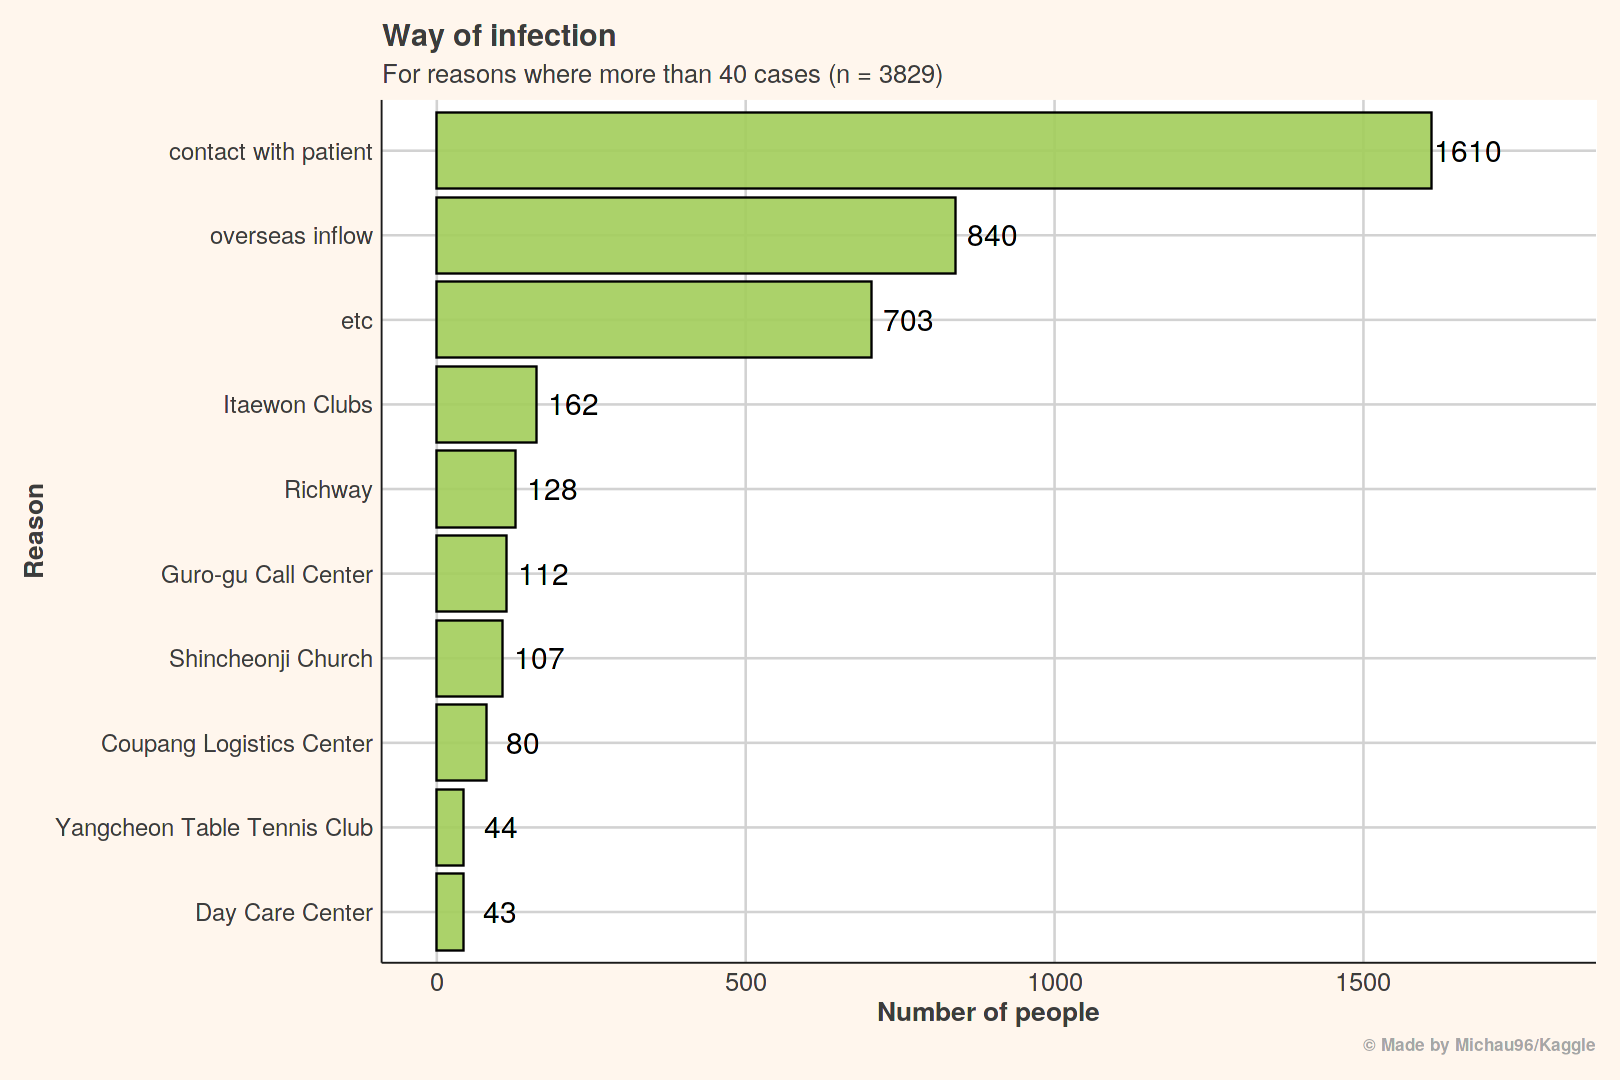

In [5]:
Table <- as.data.frame(table(data$Infection_reason))
names(Table) <- c("Reason", "n")

Table <- Table[between(Table$n, 40, 100000),]

ggplot(Table, aes(reorder(Reason, +n),n))+
  geom_bar(stat = "identity", colour = "black", fill = "darkolivegreen3", alpha = 0.9)+
  coord_flip()+
  geom_text(aes(label = n, y = n+60), size = 6.2)+
  scale_y_continuous(limits = c(0, max(Table$n)*1.11))+
  labs(title = "Way of infection", subtitle = "For reasons where more than 40 cases (n = 3829)", 
       y = "Number of people", x = "Reason", caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15.5, face = "bold"), axis.text.y = element_text(size = 14), axis.text.x = element_text(size = 15),
        plot.background = element_rect(fill = "#fff6ed"), axis.line = element_line(size = 0.4, colour = "grey10"), plot.caption = element_text(color = "gray65", face = "bold", size = 10),
        legend.background = element_rect(fill = "#fff6ed"), plot.subtitle = element_text(size = 15), panel.background = element_rect(fill = "white"))
#sum(Table$n)

We're now looking at how people were infected. **The most common reason** (among those for whom you can point) **is contact with another infected person**. Many people also became infected abroad and came to Korea already with the virus. It is also worth paying attention to the threats in places of religious worship - even over 100 people got infected in one church.

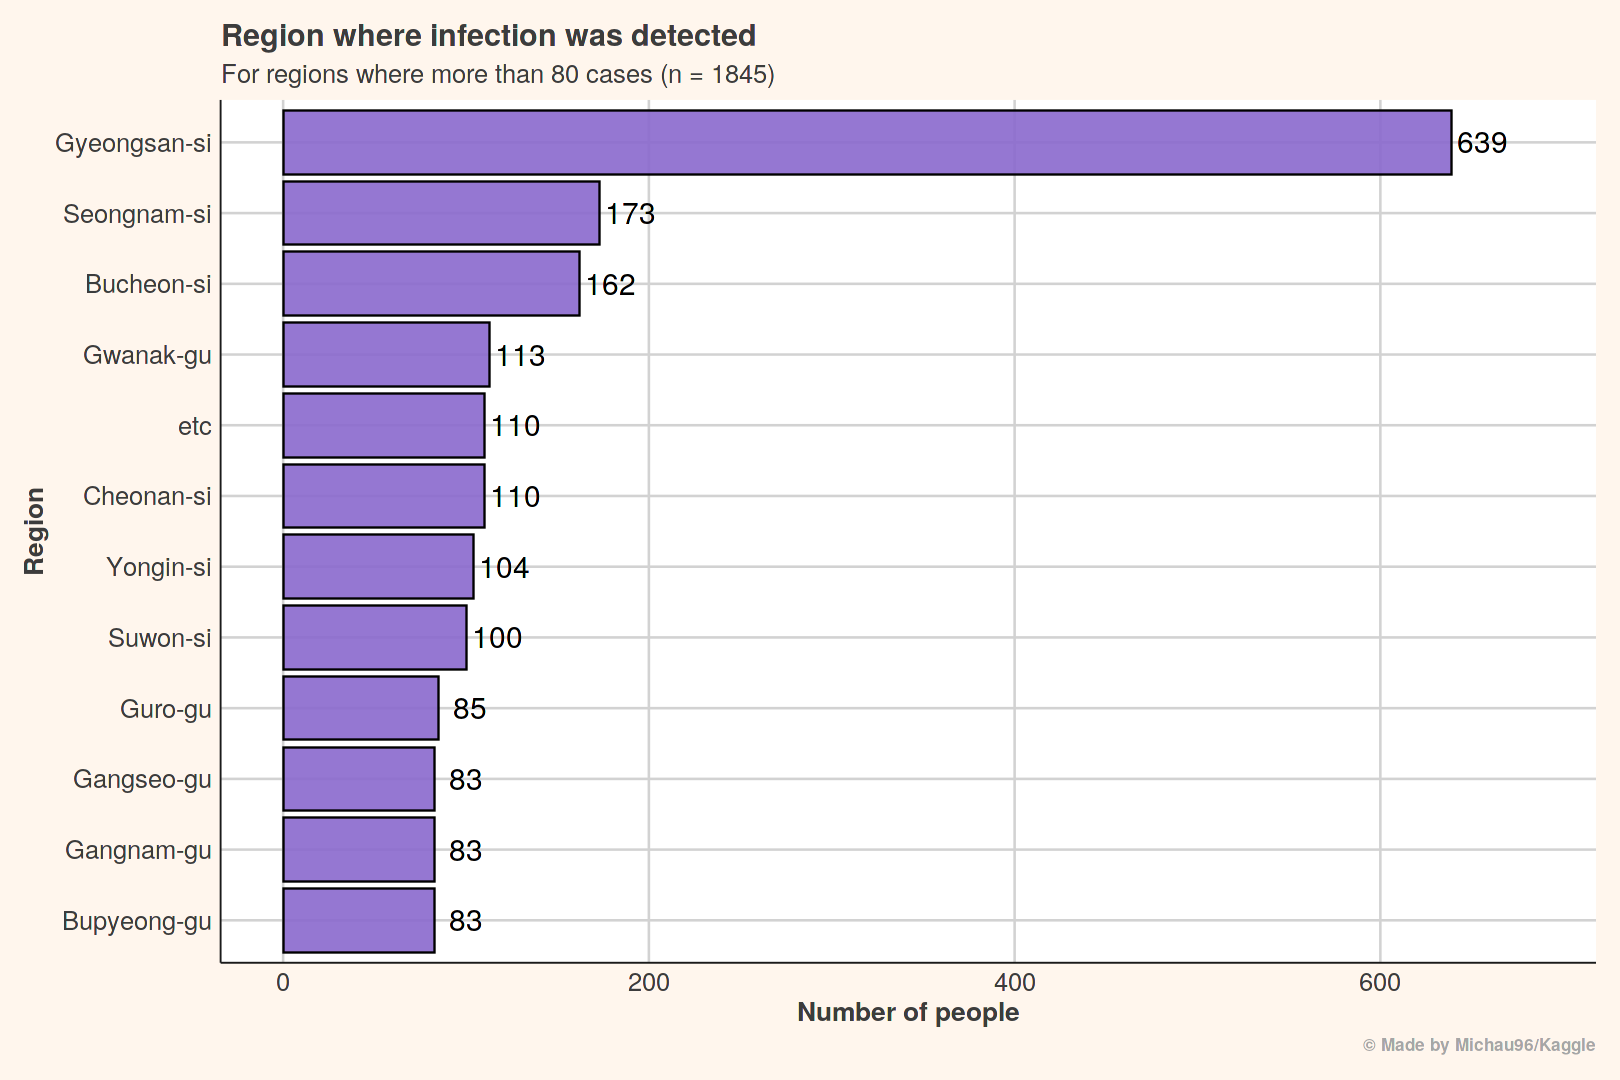

In [6]:
Table3 <- as.data.frame(table(data$Region))
names(Table3) <- c("Region", "n")
Table3 <- Table3[Table3$Region!="",]

Table3 <- Table3[between(Table3$n, 80, 100000),]

ggplot(Table3, aes(reorder(Region, +n),n))+
  geom_bar(stat = "identity", colour = "black", fill = "mediumpurple3", alpha = 0.9)+
  coord_flip()+
  geom_text(aes(label = n, y = n+17), size = 6.2)+
  scale_y_continuous(limits = c(0, max(Table3$n)*1.07))+
  labs(title = "Region where infection was detected", subtitle = "For regions where more than 80 cases (n = 1845)", 
       y = "Number of people", x = "Region", caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15.5, face = "bold"), axis.text.y = element_text(size = 15), axis.text.x = element_text(size = 15),
        plot.background = element_rect(fill = "#fff6ed"), axis.line = element_line(size = 0.4, colour = "grey10"), plot.caption = element_text(color = "gray65", face = "bold", size = 10),
        legend.background = element_rect(fill = "#fff6ed"), plot.subtitle = element_text(size = 15), panel.background = element_rect(fill = "white"))
#sum(Table3$n)

We are now looking exactly at the place where individuals were infected - again For most people we don't have this information. **Among the people for whom the region most commonly known is Gyeongsan-si** in which about 1/3 of all infected individuals identified in the country. Interestingly, the country's capital, Seoul, is only in 3rd place.

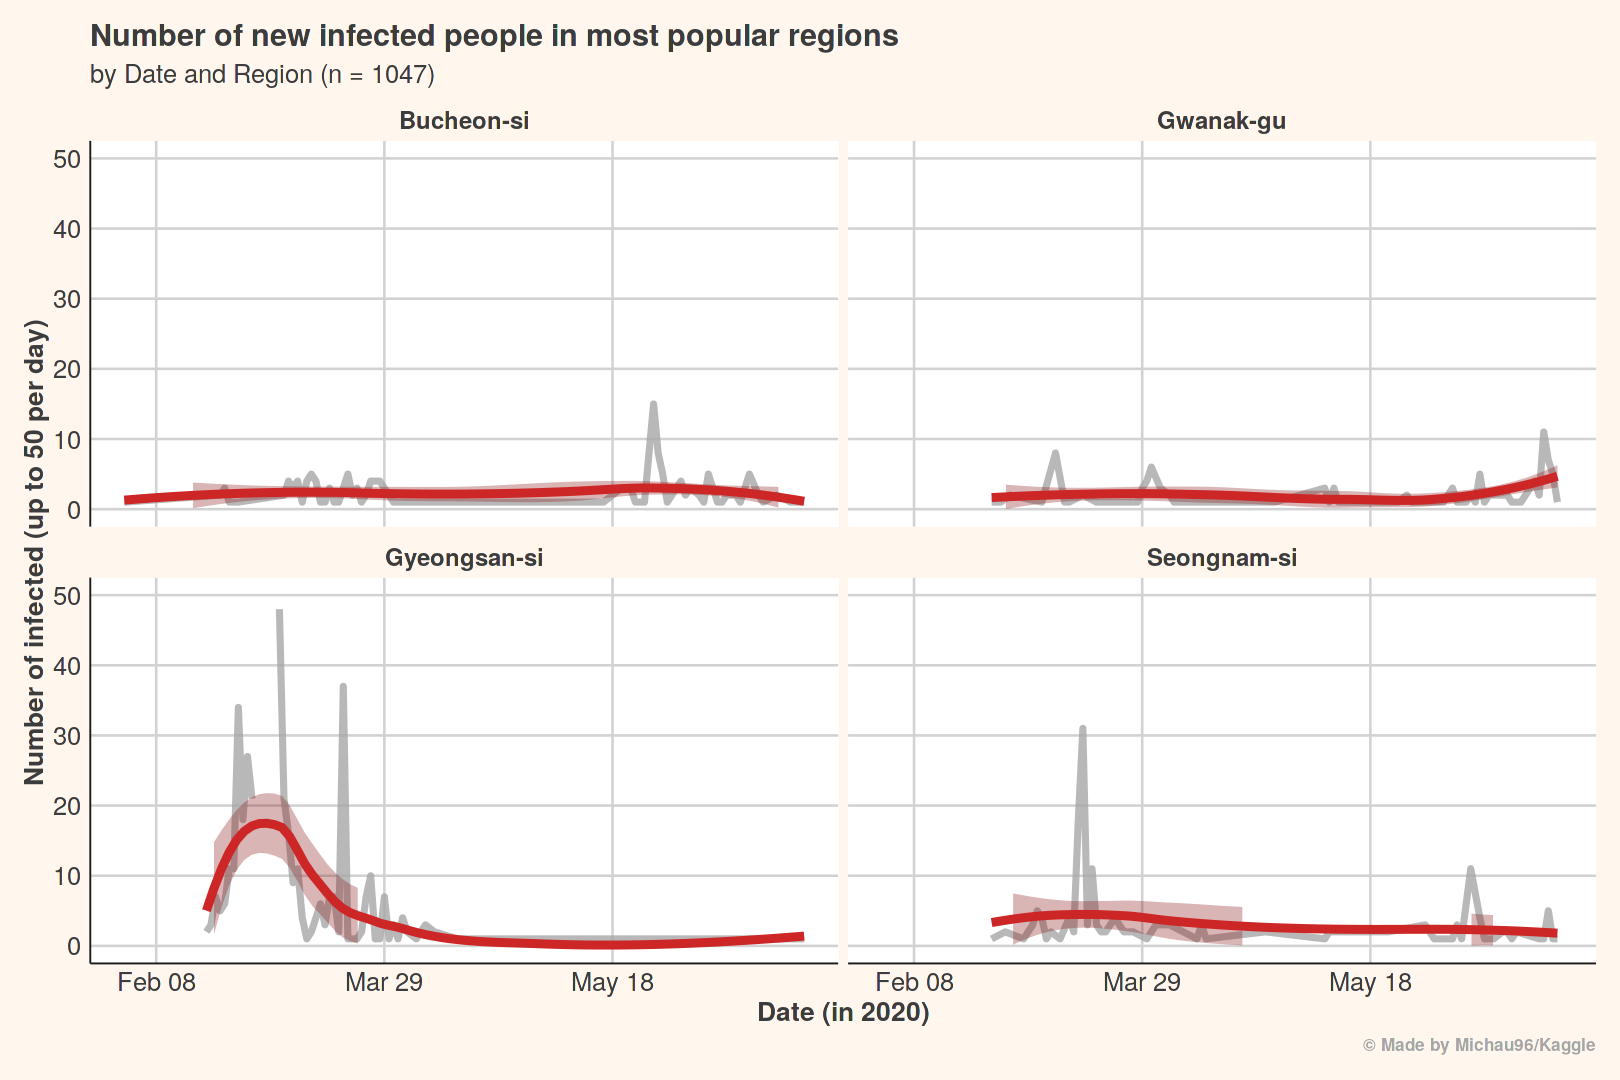

In [7]:
Table3 <- Table3[order(Table3$n, decreasing = T),]

Table4 <- data %>%
  filter(year(Date_Confirm) > 2019) %>%
  filter(Region %in% Table3[1:4,1]) %>%
  group_by(Date_Confirm, Region) %>%
  summarise(x = n())
ggplot(Table4, aes(Date_Confirm, x))+
  geom_line(size = 1.5, alpha = 0.8, col = "gray65")+
  geom_smooth(method = "loess", color = "firebrick3", size = 1.9, formula = y ~ x, fill = "firebrick4", alpha = 0.32)+
  facet_wrap(.~Region)+
  scale_y_continuous(limits = c(0,50))+
  labs(title = "Number of new infected people in most popular regions", subtitle = "by Date and Region (n = 1047)", 
       y = "Number of infected (up to 50 per day)", x = "Date (in 2020)", caption = "© Made by Michau96/Kaggle")+
  scale_x_date(date_labels = "%b %d", date_breaks = "50 days")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15.5, face = "bold"), axis.text = element_text(size = 15), plot.background = element_rect(fill = "#fff6ed"),
        strip.text.x = element_text(size = 14, face = "bold"), axis.line = element_line(size = 0.4, colour = "grey10"), plot.caption = element_text(color = "gray65", face = "bold", size = 10),
        plot.subtitle = element_text(size = 15), panel.background = element_rect(fill = "white"), strip.background = element_rect(fill = "#fff6ed"))
#sum(Table4$x)

Knowing the most popular regions where the virus has spread, we look at the new numbers identified in the four most popular regions over time. **In the region where the most cases have been identified so far, they were detected primarily between mid-February and April**. In the other three regions, it is impossible to identify the date when the virus spreads the fastest due to the relatively small number of cases detected each day (except for region Seongnam-si where more than 30 new cases were found in one day in early March).

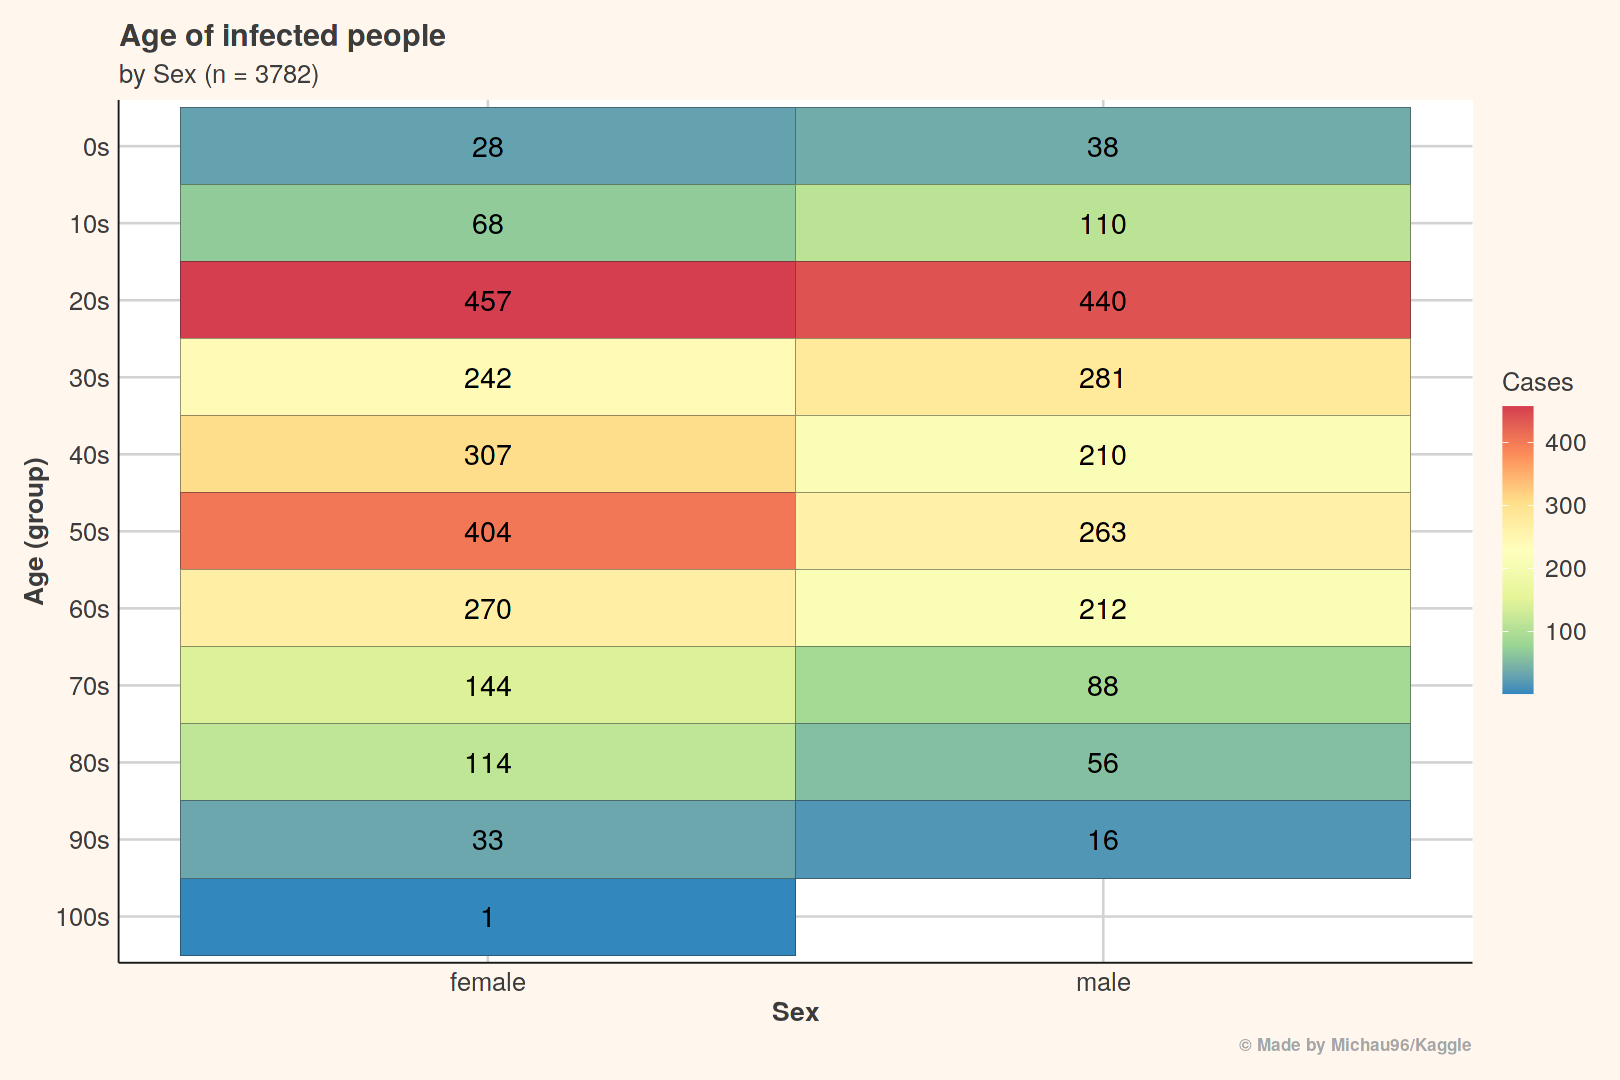

In [8]:
data_chart_age <- data %>%
  group_by(Age, Sex) %>%
  filter(Age != "") %>% 
  filter(is.na(Sex)==F) %>%
  summarise(Count = n())

ggplot(data_chart_age, aes(Sex, Age))+
  geom_tile(aes(fill = Count), colour = "gray15")+
  scale_y_discrete(limit = c("100s", "90s", "80s", "70s", "60s", "50s", "40s", "30s", "20s", "10s", "0s"))+
  scale_fill_distiller(palette = "Spectral")+
  #geom_text(aes(label = paste0(round(Count/sum(data_chart_age$Count) * 100,1), "%")), size = 5)+
  geom_text(aes(label = Count), size = 5.9)+
  guides(fill = guide_colorbar(title.position = "top", barwidth = 1.3, barheight = 12))+
  labs(title = "Age of infected people", subtitle = "by Sex (n = 3782)", 
       y = "Age (group)", x = "Sex", fill = "Cases", caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15.5, face = "bold"), axis.text = element_text(size = 15), legend.position = "right",
        legend.title = element_text(size = 15),legend.text = element_text(size = 14.5), legend.direction = 'vertical', 
        plot.background = element_rect(fill = "#fff6ed"), axis.line = element_line(size = 0.4, colour = "grey10"), plot.caption = element_text(color = "gray65", face = "bold", size = 10),
        legend.background = element_rect(fill = "#fff6ed"), plot.subtitle = element_text(size = 15), panel.background = element_rect(fill = "white"))
#sum(data_chart_age$Count)

For some cases, we also know the sex and age of infected people. **In men, we can see a unimodal distribution with a peak in people aged 20-30, while in women, a bimodal distribution with "hills" among people in their 20s and 50s**. Very young and very old people rarely suffer from this disease, nevertheless it is worth adding that old people with chronic diseases are more likely to die.

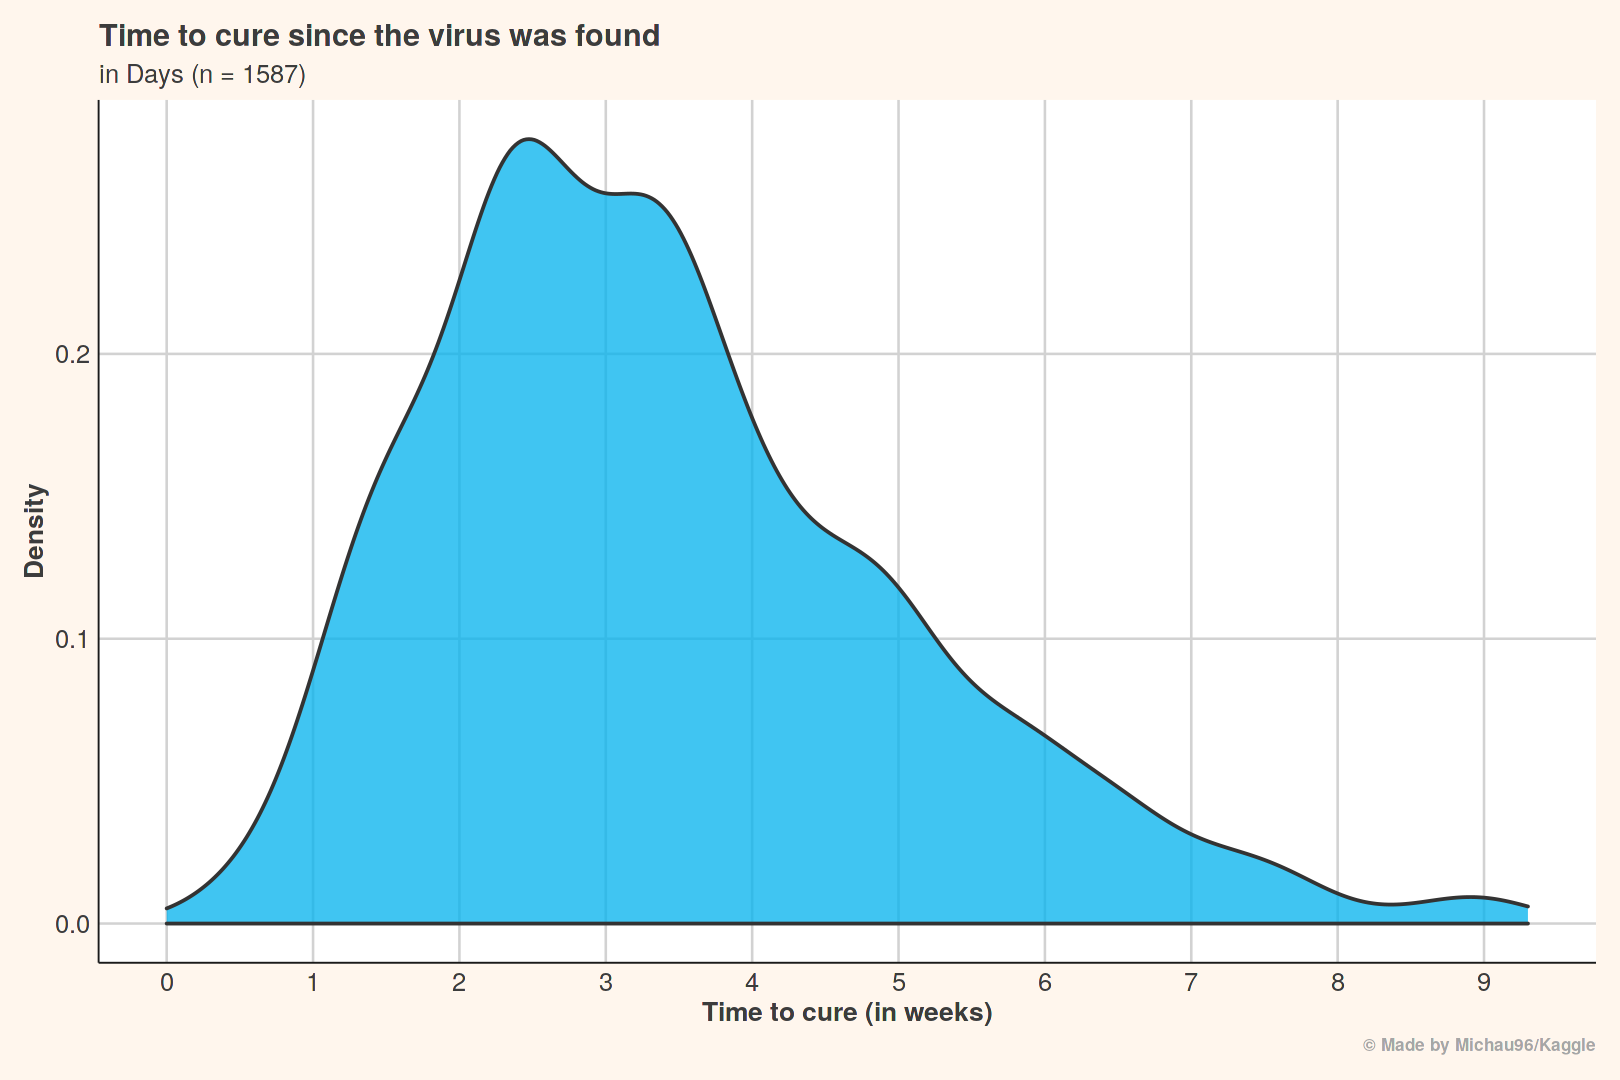

In [9]:
ggplot(data, aes(Days_To_Recover/7))+
  geom_density(alpha = 0.75, position = "stack", size = 0.8,  col = "gray20", fill = "deepskyblue2")+
  scale_x_continuous(limits = c(0,9.3), breaks = seq(0,9,1))+
  labs(title = "Time to cure since the virus was found", subtitle = "in Days (n = 1587)", 
       y = "Density", x = "Time to cure (in weeks)", caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15.5, face = "bold"), axis.text = element_text(size = 15), panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "#fff6ed"), axis.line = element_line(size = 0.4, colour = "grey10"),
        legend.background = element_rect(fill = "#fff6ed"), plot.subtitle = element_text(size = 15), plot.caption = element_text(color = "gray65", face = "bold", size = 10))
#nrow(data)-sum(is.na(data$Days_To_Recover))

We're now looking at the people being treated. We check how much time they needed to recover from the time they were diagnosed with the infection (positive coronavrius test). **The time distribution for such people has a right distribution and most people needed between 15 and 23 days**. Cases over a month are very rare, however, it has often happened that only a few days after diagnosis, people could already be considered healthy.

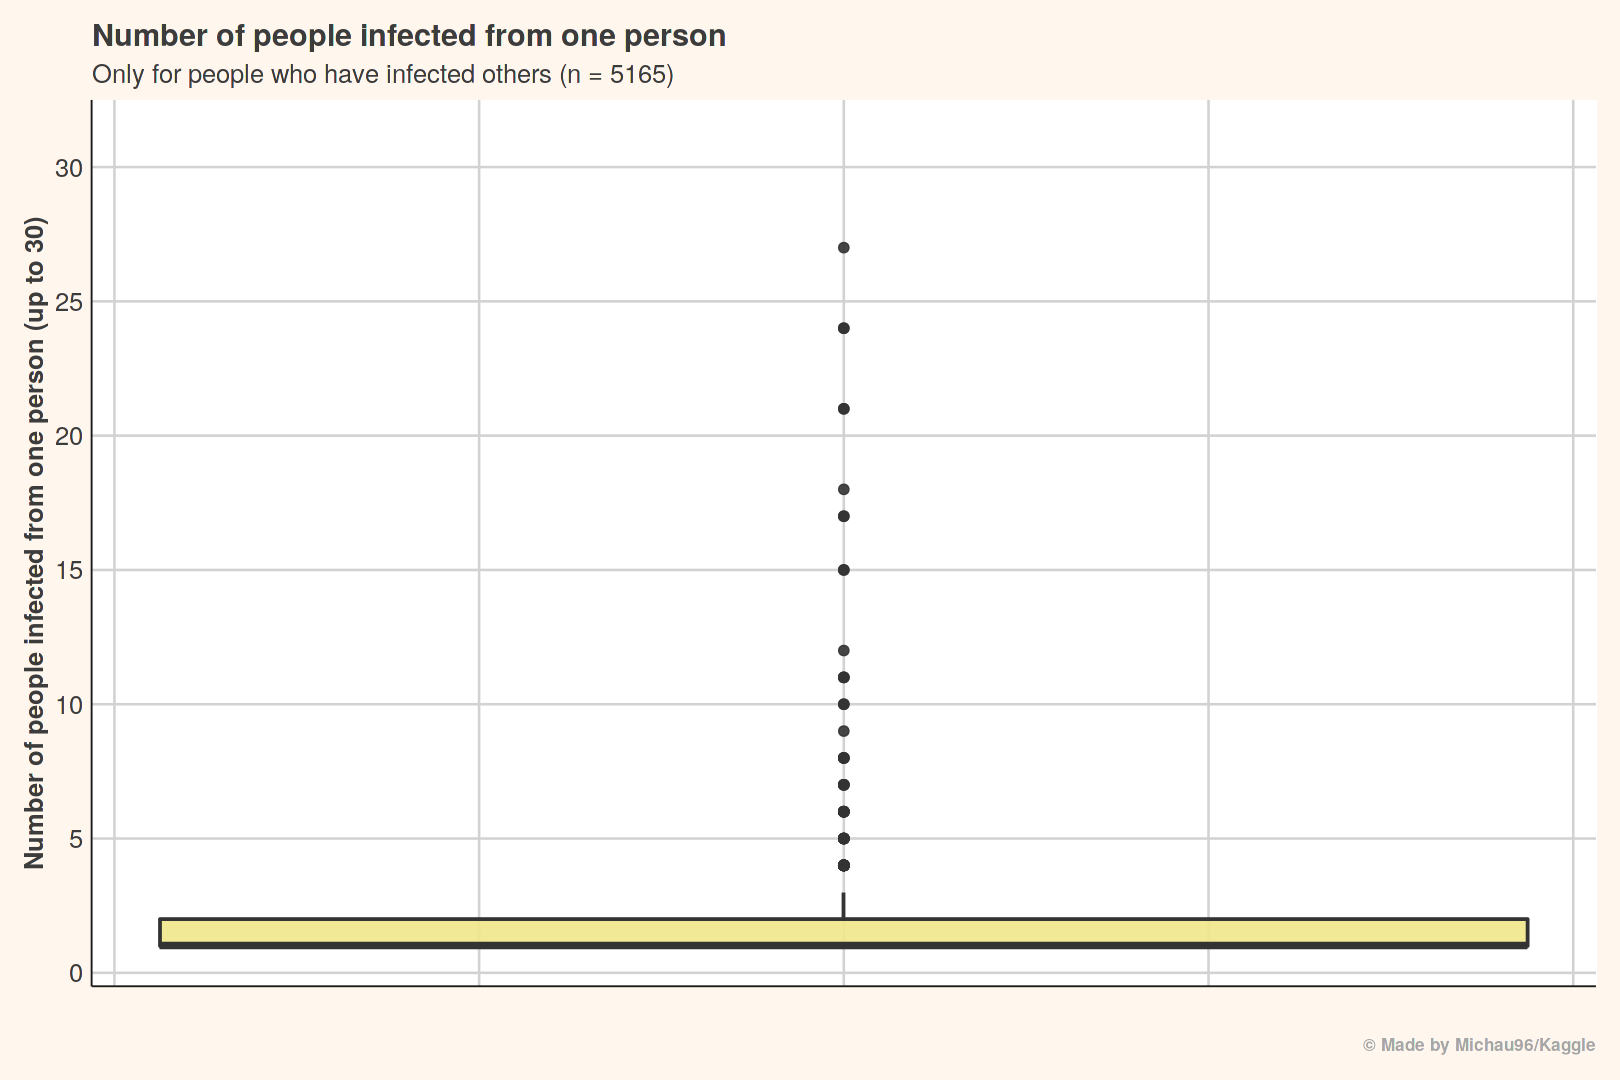

In [10]:
Table2 <- as.data.frame(table(data$Infected_by))
names(Table2) <- c("ID", "n")
Table2$ID <- as.factor(Table2$ID)

ggplot(Table2, aes(n))+
  geom_boxplot(outlier.size = 3.5, outlier.shape = 20, lwd = 0.8, fatten = 2, fill = "khaki", alpha = 0.9)+
  labs(title = "", subtitle = "", y = "", x = "")+
  coord_flip()+
  scale_x_continuous(limits = c(1,31), breaks = seq(0,30,5))+
  labs(title = "Number of people infected from one person", subtitle = "Only for people who have infected others (n = 5165)", 
       x = "Number of people infected from one person (up to 30)", caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15, face = "bold"), axis.text = element_text(size = 15), panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "#fff6ed"), axis.line = element_line(size = 0.4, colour = "grey10"), plot.caption = element_text(color = "gray65", face = "bold", size = 10),
        legend.background = element_rect(fill = "#fff6ed"), axis.text.x = element_text(size = 0), plot.subtitle = element_text(size = 15))
#sum(Table2$n)

For some people it can be clearly stated which person caused the infection. So far, it has not been found that anyone has infected more than 27 people and at the same time. **More than half of the people who know that they have infected others have infected only one person.**

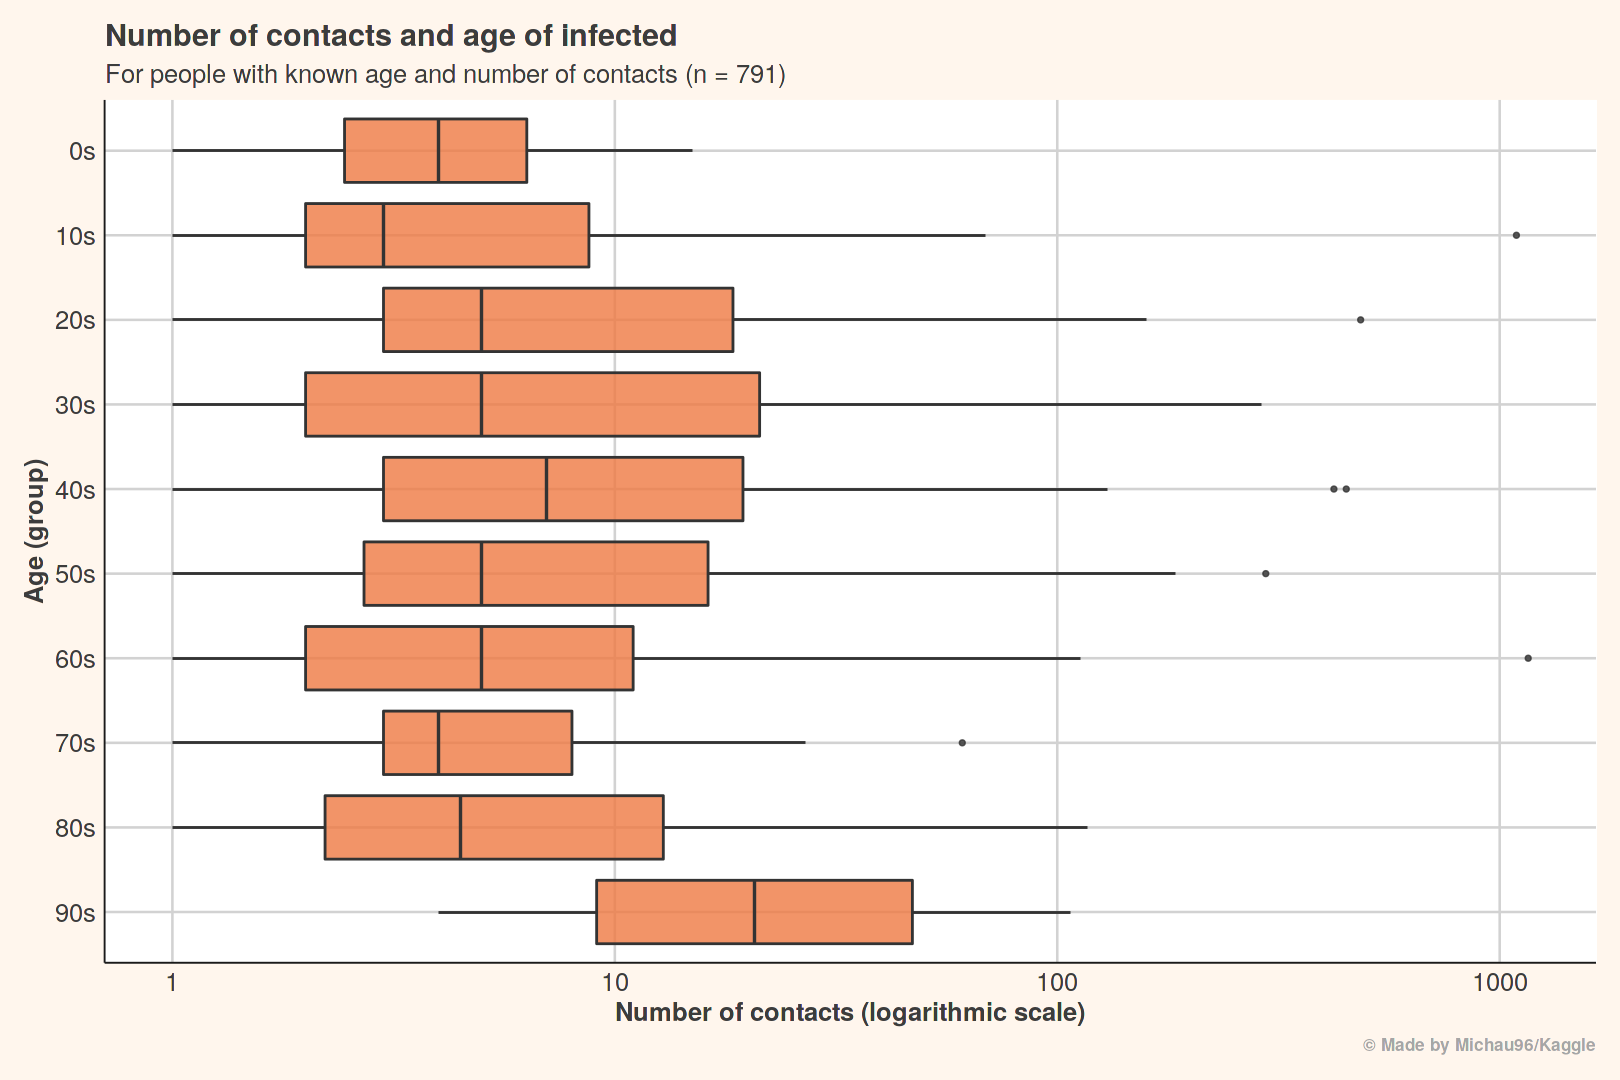

In [11]:
data %>%
  filter(Contact_number < 100000) %>%
ggplot(., aes(Contact_number, Age))+
  geom_boxplot(outlier.size = 1.7, outlier.shape = 20, lwd = 0.6, fatten = 1.2, fill = "sienna2", alpha = 0.8)+
  scale_x_continuous(trans = "log10")+
  scale_y_discrete(limit = c("90s", "80s", "70s", "60s", "50s", "40s", "30s", "20s", "10s", "0s"))+
  labs(title = "Number of contacts and age of infected", subtitle = "For people with known age and number of contacts (n = 791)", 
       x = "Number of contacts (logarithmic scale)", y = "Age (group)", caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15, face = "bold"), axis.text = element_text(size = 15), panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "#fff6ed"), axis.line = element_line(size = 0.4, colour = "grey10"),
        legend.background = element_rect(fill = "#fff6ed"), plot.subtitle = element_text(size = 15), plot.caption = element_text(color = "gray65", face = "bold", size = 10))
#sum(table(data$Age, data$Contact_number))

We are now looking at age of the infected and the number of contacts. We have both of this information for just a few dozen patients, so no conclusions can be drawn for the entire population. **There is no clear relationship between age and the number of contacts.** It's worth adding that a small number of people had a lot of contacts, which strongly affects the distribution.

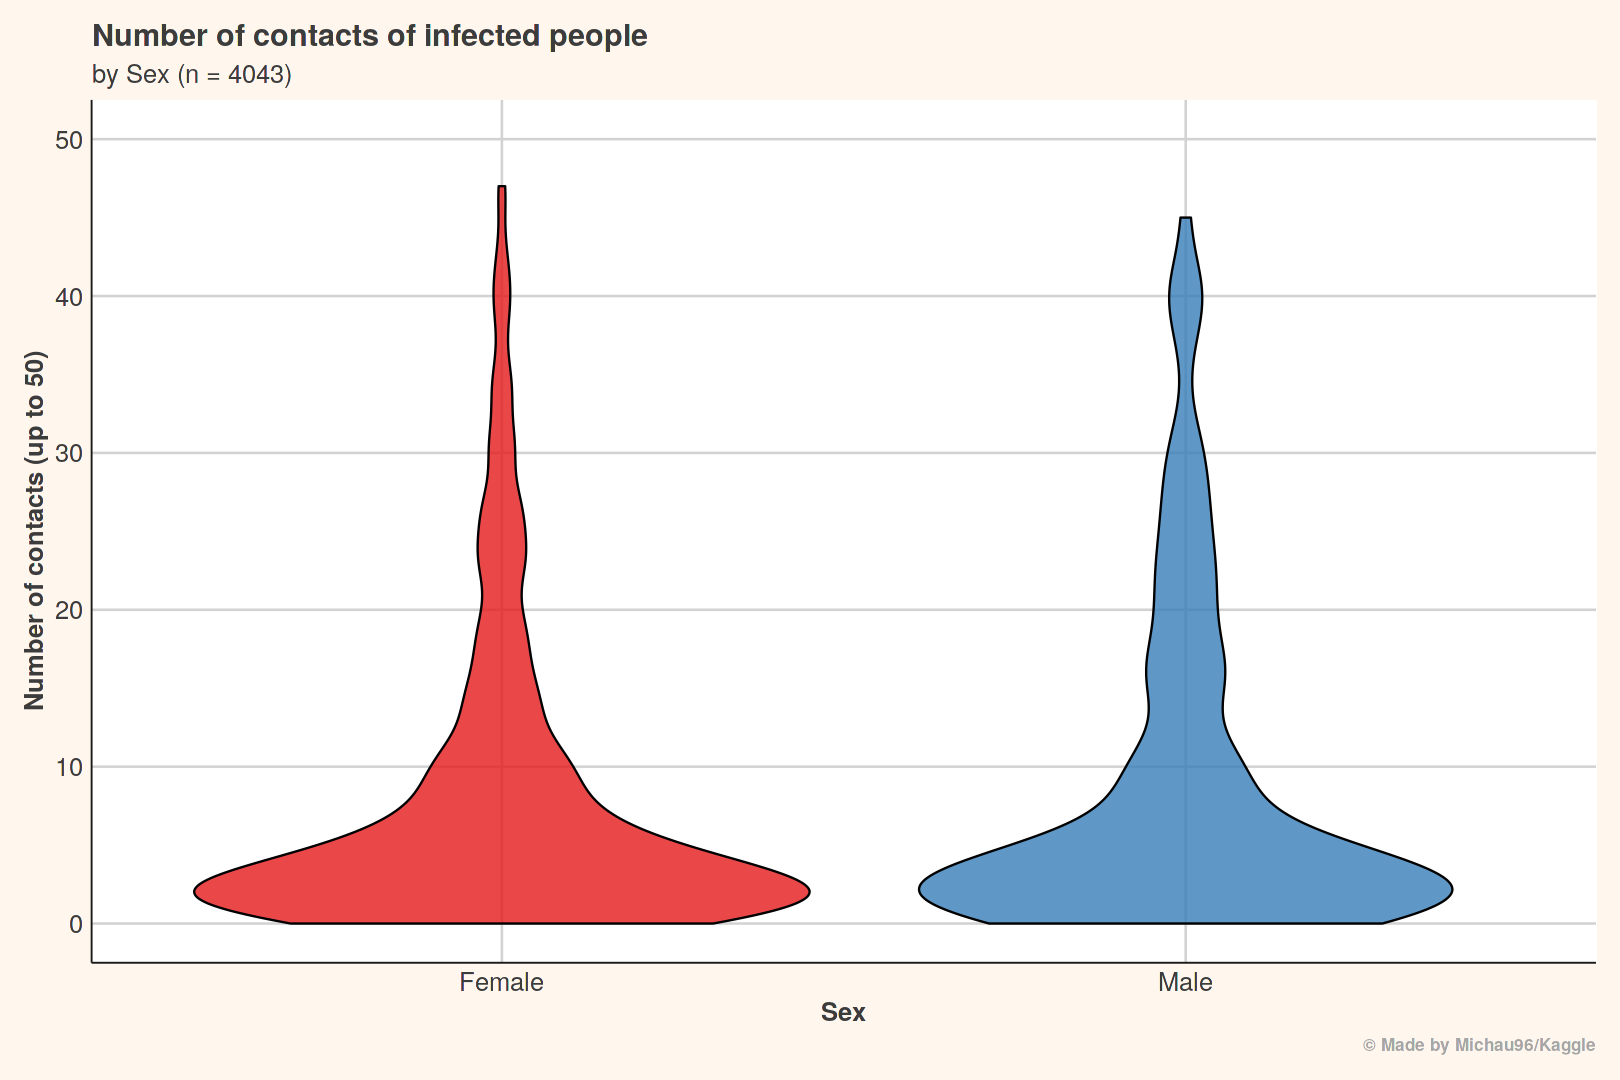

In [12]:
data[data$Sex %in% c("female", "male"), ] %>%
 ggplot(., aes(x = Sex, y = Contact_number, fill = Sex))+
  geom_violin(alpha = 0.8, col = "black")+
  scale_y_continuous(limits = c(0,50), breaks = seq(0,50,10))+
  scale_x_discrete(labels = c("Female","Male"))+
  scale_fill_brewer(palette = "Set1")+
  labs(title = "Number of contacts of infected people", subtitle = "by Sex (n = 4043)", 
       x = "Sex", y = "Number of contacts (up to 50)", fill = "Sex", caption = "© Made by Michau96/Kaggle")+
  theme_fivethirtyeight()+
  theme(axis.title = element_text(size = 15, face = "bold"), axis.text = element_text(size = 15), legend.position = "none", 
        legend.direction = 'horizontal',plot.background = element_rect(fill = "#fff6ed"), plot.subtitle = element_text(size = 15),
        axis.line = element_line(size = 0.4, colour = "grey10"), panel.background = element_rect(fill = "white"), plot.caption = element_text(color = "gray65", face = "bold", size = 10))
#nrow(data[data$Sex %in% c("female", "male"), ])

At the end we look at the number of contacts again, but this time broken down by gender. **Looking at the median, men have an average of several contacts more than women**. The 3 quartile and unusual values confirm the conclusion that infected men have more contacts than women, but these differences are not large.

**Main Conclusions:**

* By the end of February, the number of new infected in Korea was growing rapidly, but since then the number of new cases has been decreasing day by day,

* The most common reason for infection is contact with another already infected person,

* They are most often found in the Gyeongsangbuk-do (region in the east of the country),

* The most frequently infected people are people between 20 and 30 years old and between 50 and 60 (slightly more often women than men),

* Recovery time is usually between 2 and 3.5 weeks,

* Information on the number of contacts is inaccurate so much that we cannot draw a meaningful conclusion except, that the infected men had slightly more contacts than infected women.






**Thanks for reading my kernal!**

**If you have any suggestions for improving the analysis, let me know in the comment!**

**If you liked my kernel, give upvote!**

**If you have a moment, I recommend looking at [my other projects](https://www.kaggle.com/michau96/notebooks).**